### Balanced Multi-Agent Route Optimization (TSP Variant)

#### Problem Overview

We are given a set of geographic locations (latitude & longitude) and a fixed number of agents. The objective is to assign each location to exactly one agent and determine a route per agent such that:

- All locations are visited exactly once
- Each agent travels a closed route
- Total distance across all agents is minimized
- Route distances are as balanced as possible across agents
- Distances respect Earth curvature (not Euclidean)

This problem is a real-world variant of the Traveling Salesman Problem (TSP) and can be framed as a **multi-agent Vehicle Routing Problem (VRP)** with a fairness constraint.

In [6]:
# Library imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import radians, sin, cos, sqrt, atan2
from sklearn.cluster import KMeans
from collections import defaultdict
import random

#### Distance Metric: Haversine (Geodesic)

Straight-line Euclidean distances are not appropriate for latitude/longitude data.
We therefore use the **Haversine formula**, which computes great-circle distances on the Earth’s surface.

This ensures:
- Realistic routing
- Curved paths on maps
- Correct distance comparisons

In [7]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # Earth radius in km

    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    return R * c

#### Load and Inspect Data

The dataset contains geographic coordinates for all locations.
Each row represents a unique location that must be visited exactly once.

In [8]:
# Using pandas since dataset is not large.
df = pd.read_excel("/content/TSP1.xlsm")

# Ensure expected columns exist
df = df.rename(columns=str.lower)

assert "latitude" in df.columns and "longitude" in df.columns

print(f"Total locations: {len(df)}")
df.head()

Total locations: 3957


,latitude,longitude,organization name,phone number
0,6.484425,3.363048,Organisation Name 1,Shop1
1,6.493842,3.337467,Organisation Name 2,Shop2
2,6.647137,3.349124,Organisation Name 3,Shop3
3,6.622690,3.329732,Organisation Name 4,Shop4
4,6.476198,3.330194,Organisation Name 5,Shop5


In [9]:
# Check some basic info for numerical columns

df.describe()

,latitude,longitude
count,3957.000000,3957.000000
mean,6.555146,3.343269
std,0.189159,0.071548
min,0.091410,0.787248
25%,6.497535,3.335926
50%,6.577688,3.344104
75%,6.619807,3.355291
max,6.702703,3.380673


In [10]:
# Check basic info for categorical columns

df.describe(exclude=np.number)

,organization name,phone number
count,3957,3957
unique,3957,3957
top,Organisation Name 3957,Shop3957
freq,1,1


In [11]:
# Check if data is pre-cleaned

missing_counts = df.isnull().sum()

if (missing_counts > 0).any():
    print("Missing values found:")
    print(missing_counts[missing_counts > 0])
else:
    print("Data is pre-cleaned")

Data is pre-cleaned


#### Geographic Distribution of Locations

Before optimization, we visualize all locations to understand spatial density and scale.

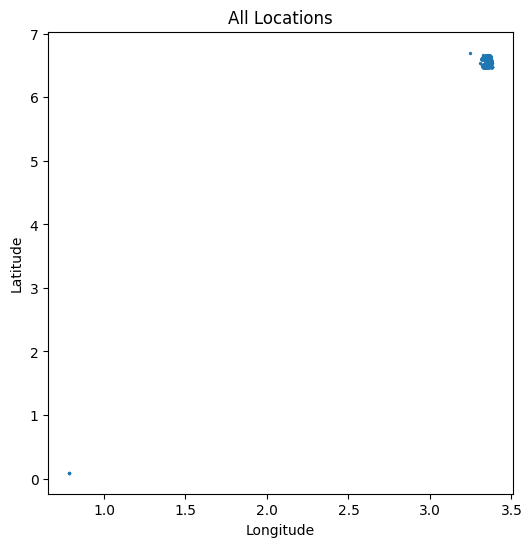

In [12]:

# First-level scatter plot

plt.figure(figsize=(6, 6))
plt.scatter(df["longitude"], df["latitude"], s=2)
plt.title("All Locations")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

From this, we can already diagnose a problem that the scatter plot suffers from:

- High point density → massive overplotting


- Tight geographic extent → points collapse visually


- No spatial context → can’t see neighborhoods, boundaries, or clusters


- Lat/Lon scatter ignores geography semantics

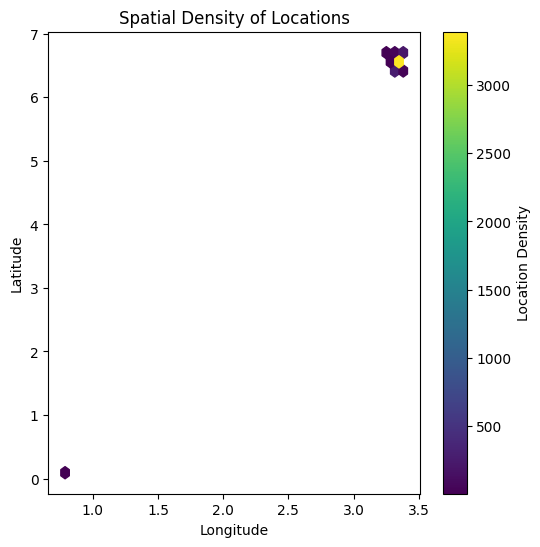

In [13]:
# A First-layer Hexbin for clarity
plt.figure(figsize=(6, 6))
plt.hexbin(
    df["longitude"],
    df["latitude"],
    gridsize=40,
    cmap="viridis",
    mincnt=1
)
plt.colorbar(label="Location Density")
plt.title("Spatial Density of Locations")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

Exploratory spatial density analysis show a small, geographically isolated subset of locations far from themain operational area. Including these locations in the same optimization pool would force excessive travel and violate route balance assumptions.


This means that this problem is not one connected TSP instance. In fact, it is at least two disconnected geographic regions. If we ignore this, then one agent will be forced to travel hundreds of kilometers extra and our “balanced routing” objective becomes mathematically impossible.

We therefore need to handle this subset as a separate routing component, assigning it to a dedicated agent.

Distance to Global Centroid (Outlier Detection)

In [14]:
# Compute global centroid
center_lat = df.latitude.mean()
center_lon = df.longitude.mean()

df["dist_to_center_km"] = df.apply(
    lambda r: haversine(r.latitude, r.longitude, center_lat, center_lon),
    axis=1
)

df["dist_to_center_km"].describe()

,dist_to_center_km
count,3957.000000
mean,7.596771
std,21.158414
min,2.296986
25%,5.499105
50%,7.013473
75%,8.407403
max,772.658215


From distances, we see that:

- 75% of all points are within 8.4 km of the centroid


- Median is ~7 km, very tight


- Standard deviation is large (21 km) only because of extreme values


- Max is 772 km:→ it is a true geographic outlier

#### Spatial Density Visualization (Log-Scaled)

To better understand point concentration and detect disconnected regions,
we visualize spatial density using hexagonal binning with logarithmic scaling.

This avoids overplotting and highlights true geographic structure.

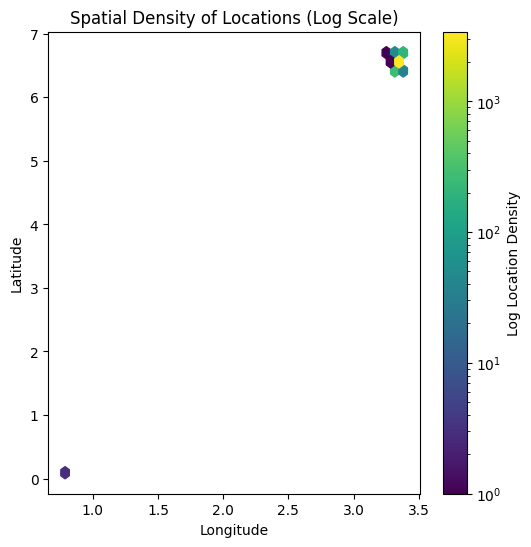

In [15]:
# Improved Hexbin with Log scales

plt.figure(figsize=(6, 6))
plt.hexbin(
    df["longitude"],
    df["latitude"],
    gridsize=40,
    bins="log",
    cmap="viridis"
)
plt.colorbar(label="Log Location Density")
plt.title("Spatial Density of Locations (Log Scale)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

The density plot and centroid distances reveal a small set of locations
that are geographically isolated from the main operational area.

Including these locations in the same routing pool would force one agent
to travel disproportionately long distances, violating route balance objectives.

We therefore separate the dataset into:
- Main connected component (primary optimization target)
- Isolated outlier component (handled independently)



Also:

Using the output of the centroid, we identify geographic outliers using a robust, distribution-based threshold (Q3 + 5×IQR) to avoid arbitrary distance cutoffs.

In [16]:
# Threshold chosen conservatively based on observed scale

Q1 = df["dist_to_center_km"].quantile(0.25)
Q3 = df["dist_to_center_km"].quantile(0.75)
IQR = Q3 - Q1

OUTLIER_THRESHOLD_KM = Q3 + 5 * IQR
OUTLIER_THRESHOLD_KM

main_df = df[df.dist_to_center_km <= OUTLIER_THRESHOLD_KM].copy()
outlier_df = df[df.dist_to_center_km > OUTLIER_THRESHOLD_KM].copy()

print(f"Main region locations: {len(main_df)}")
print(f"Outlier locations: {len(outlier_df)}")

Main region locations: 3954
Outlier locations: 3


#### Outlier Handling

Three locations are geographically isolated from the main region.
We assign these to a dedicated agent to avoid distorting route balance
for the remaining agents. This ensures fairness and preserves optimization quality.

#### Agent Allocation Strategy

We have a total of 41 agents available.

- 1 agent will dedicated to the isolated outlier region (3 locations)
- The remaining 40 agents are allocated to the main connected region (3954 locations)

This separation prevents extreme route imbalance while keeping the overall
agent utilization transparent and explainable.


In [17]:
# Agent Count Configuration

TOTAL_AGENTS = 41
OUTLIER_AGENTS = 1
MAIN_AGENTS = TOTAL_AGENTS - OUTLIER_AGENTS

MAIN_AGENTS

40

#### Balanced Clustering of the Main Region

We now partition the 3954 main-region locations into 40 geographically compact clusters.
Each cluster corresponds to one agent.

Clustering is performed **only on geographic proximity** to ensure contiguous regions.
Workload balance is later refined at the routing level.


In [18]:
# K-Means Clustering (Main Region Only)

from sklearn.cluster import KMeans

coords_main = main_df[["latitude", "longitude"]].values

kmeans = KMeans(
    n_clusters=MAIN_AGENTS,
    random_state=42,
    n_init=20
)

main_df["agent"] = kmeans.fit_predict(coords_main)

The three isolated locations are assigned to a dedicated agent.


In [19]:
# Outlier Assignment

OUTLIER_AGENT_ID = MAIN_AGENTS  # last agent index

outlier_df["agent"] = OUTLIER_AGENT_ID


We recombine the main and outlier datasets and validate agent workloads
before route optimization.


In [20]:
# Cluster_size Distribution

combined_df = pd.concat([main_df, outlier_df], ignore_index=True)

cluster_sizes = combined_df["agent"].value_counts().sort_index()
cluster_sizes

,count
agent,
0,223
1,139
2,150
3,162
4,84
5,103
6,173
7,76
8,13


#### Cluster Balance Check

Initial KMeans clustering produces significant imbalance in the number of
locations per agent. Since KMeans optimizes only spatial compactness, a
post-processing rebalancing step is required to satisfy workload fairness.


In [21]:
# Define Target Capacity

TARGET_SIZE = int(len(main_df) / MAIN_AGENTS)
LOWER_BOUND = int(TARGET_SIZE * 0.8)
UPPER_BOUND = int(TARGET_SIZE * 1.2)

TARGET_SIZE, LOWER_BOUND, UPPER_BOUND

(98, 78, 117)

In [22]:
# Identify Problematic Clusters

cluster_sizes = main_df["agent"].value_counts()

overloaded = cluster_sizes[cluster_sizes > UPPER_BOUND].index.tolist()
underloaded = cluster_sizes[cluster_sizes < LOWER_BOUND].index.tolist()

len(overloaded), len(underloaded)

(12, 13)

#### Capacity-Constrained Cluster Rebalancing

To satisfy workload balance requirements, we rebalance KMeans clusters by
moving boundary locations from overloaded clusters to nearby underloaded ones.
Moves are selected to minimize geographic distortion while enforcing
capacity constraints.


In [23]:
# Compute centroids of each cluster
centroids = (
    main_df
    .groupby("agent")[["latitude", "longitude"]]
    .mean()
)

In [24]:
# %pip install haversine
from haversine import haversine

def distance_to_centroid(row, centroid):
    return haversine(
        (row.latitude, row.longitude),
        (centroid.latitude, centroid.longitude)
    )

In [25]:
# Re-balancing Loop

main_df = main_df.copy()

cluster_sizes = main_df["agent"].value_counts().to_dict()

overloaded = {k for k, v in cluster_sizes.items() if v > UPPER_BOUND}
underloaded = {k for k, v in cluster_sizes.items() if v < LOWER_BOUND}

MAX_ITER = 10_000
iteration = 0

while overloaded and underloaded and iteration < MAX_ITER:
    iteration += 1

    # Pick the most overloaded cluster
    src = max(overloaded, key=lambda k: cluster_sizes[k])

    # Candidate points: farthest from its own centroid
    src_points = main_df[main_df.agent == src].copy()
    src_centroid = centroids.loc[src]

    src_points["dist_from_src"] = src_points.apply(
        lambda r: distance_to_centroid(r, src_centroid),
        axis=1
    )

    src_points = src_points.sort_values("dist_from_src", ascending=False)

    moved = False

    for idx, row in src_points.iterrows():

        # Find closest underloaded cluster
        best_dst = None
        best_dist = float("inf")

        for dst in underloaded:
            d = haversine(
                (row.latitude, row.longitude),
                (centroids.loc[dst].latitude, centroids.loc[dst].longitude)
            )
            if d < best_dist:
                best_dist = d
                best_dst = dst

        # Execute move
        main_df.at[idx, "agent"] = best_dst
        cluster_sizes[src] -= 1
        cluster_sizes[best_dst] += 1

        moved = True

        # Update sets
        if cluster_sizes[src] <= UPPER_BOUND:
            overloaded.discard(src)
        if cluster_sizes[best_dst] >= LOWER_BOUND:
            underloaded.discard(best_dst)

        break  # move one point at a time

    if not moved:
        break

iteration


416

We validate that all clusters now fall within the target capacity range.


In [26]:
# Validate cluster sizes

final_sizes = main_df["agent"].value_counts().sort_index()

final_sizes.describe(), final_sizes

(count     40.000000
 mean      98.850000
 std       19.032428
 min       78.000000
 25%       78.000000
 50%       99.000000
 75%      123.000000
 max      124.000000
 Name: count, dtype: float64,
 agent
 0     123
 1     123
 2     123
 3     123
 4      84
 5     103
 6     123
 7      78
 8      78
 9     124
 10     97
 11     92
 12    104
 13     78
 14     78
 15    124
 16     85
 17    104
 18     98
 19    100
 20    111
 21     78
 22     78
 23    124
 24    102
 25     78
 26     78
 27    110
 28    124
 29    123
 30     78
 31    120
 32     78
 33    105
 34     79
 35     88
 36     78
 37     78
 38     78
 39    124
 Name: count, dtype: int64)

#### Final Capacity Tightening

A final pass ensures that no agent exceeds the defined upper capacity bound,
while preserving geographic compactness.


In [27]:
# Recompute centroids after first rebalance
centroids = (
    main_df
    .groupby("agent")[["latitude", "longitude"]]
    .mean()
)

cluster_sizes = main_df["agent"].value_counts().to_dict()

over_cap = {k for k, v in cluster_sizes.items() if v > UPPER_BOUND}
under_target = {k for k, v in cluster_sizes.items() if v < TARGET_SIZE}

while over_cap and under_target:
    src = max(over_cap, key=lambda k: cluster_sizes[k])

    src_points = main_df[main_df.agent == src].copy()
    src_centroid = centroids.loc[src]

    src_points["dist"] = src_points.apply(
        lambda r: haversine(
            (r.latitude, r.longitude),
            (src_centroid.latitude, src_centroid.longitude)
        ),
        axis=1
    )

    src_points = src_points.sort_values("dist", ascending=False)

    moved = False

    for idx, row in src_points.iterrows():
        dst = min(
            under_target,
            key=lambda k: haversine(
                (row.latitude, row.longitude),
                (centroids.loc[k].latitude, centroids.loc[k].longitude)
            )
        )

        main_df.at[idx, "agent"] = dst
        cluster_sizes[src] -= 1
        cluster_sizes[dst] += 1

        if cluster_sizes[src] <= UPPER_BOUND:
            over_cap.discard(src)
        if cluster_sizes[dst] >= TARGET_SIZE:
            under_target.discard(dst)

        moved = True
        break

    if not moved:
        break


In [28]:
# Validate cluster sizes

final_sizes = main_df["agent"].value_counts().sort_index()

final_sizes.describe(), final_sizes

(count     40.000000
 mean      98.850000
 std       15.234155
 min       78.000000
 25%       84.250000
 50%       99.000000
 75%      117.000000
 max      117.000000
 Name: count, dtype: float64,
 agent
 0     117
 1     117
 2     117
 3     117
 4      86
 5     103
 6     117
 7      78
 8      79
 9     117
 10     98
 11     98
 12    104
 13     78
 14     80
 15    117
 16     92
 17    104
 18     98
 19    100
 20    111
 21     78
 22     78
 23    117
 24    102
 25     85
 26     86
 27    110
 28    117
 29    117
 30     78
 31    117
 32     82
 33    105
 34     93
 35     98
 36     81
 37     87
 38     78
 39    117
 Name: count, dtype: int64)

Distribution sanity

- Median = 99 → centered

- IQR = [84.25, 117] → tight upper bound

- No degenerate clusters

- Exactly 40 agents, as intended

#### Final Route Optimization (Per Agent)

Each agent independently solves a Traveling Salesman Problem (TSP)
over its assigned locations using:
- Nearest-neighbor initialization
- 2-opt local refinement
- Haversine distance (Earth-curved)

This ensures realistic travel distances and balanced workloads.


In [29]:
# Haversine Distance Matrix

def compute_distance_matrix(coords):
    n = len(coords)
    dist = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            d = haversine(
                (coords[i][0], coords[i][1]),
                (coords[j][0], coords[j][1])
            )
            dist[i, j] = d
            dist[j, i] = d
    return dist

In [30]:
# TSP Helpers

def route_distance(route, dist):
    return sum(dist[route[i], route[i + 1]] for i in range(len(route) - 1))


def nearest_neighbor(dist):
    n = len(dist)
    visited = [False] * n
    route = [0]
    visited[0] = True

    for _ in range(n - 1):
        last = route[-1]
        next_city = min(
            (i for i in range(n) if not visited[i]),
            key=lambda i: dist[last][i]
        )
        route.append(next_city)
        visited[next_city] = True

    route.append(route[0])
    return route

def two_opt(route, dist, max_iter=50):
    best = route
    best_dist = route_distance(route, dist)

    for _ in range(max_iter):
        improved = False
        for i in range(1, len(route) - 2):
            for j in range(i + 1, len(route) - 1):
                if j - i == 1:
                    continue

                new_route = route[:i] + route[i:j][::-1] + route[j:]
                new_dist = route_distance(new_route, dist)

                if new_dist < best_dist:
                    best, best_dist = new_route, new_dist
                    improved = True

        route = best
        if not improved:
            break

    return best

In [31]:
# Tine Helpers to check runtime for audit and compare need for optimising runs

import time
from contextlib import contextmanager

@contextmanager
def timeit(label="Block"):
    start = time.time()
    yield
    end = time.time()
    elapsed = end - start
    hrs, rem = divmod(elapsed, 3600)
    mins, secs = divmod(rem, 60)
    print(f"{label} runtime: {int(hrs):02d}:{int(mins):02d}:{secs:.4f} seconds")


In [28]:
with timeit("Compute agent routes"):
    agent_routes = {}
    agent_distances = {}

    for agent_id in sorted(combined_df.agent.unique()):
        sub = combined_df[combined_df.agent == agent_id].reset_index(drop=True)
        coords = sub[["latitude", "longitude"]].values

        if len(coords) <= 1:
            continue

        dist_matrix = compute_distance_matrix(coords)
        nn_route = nearest_neighbor(dist_matrix)

        # Skip expensive refinement for small routes
        if len(coords) < 30:
            opt_route = nn_route
        else:
            opt_route = two_opt(nn_route, dist_matrix)

        agent_routes[agent_id] = opt_route
        agent_distances[agent_id] = route_distance(opt_route, dist_matrix)


Compute agent routes runtime: 00:04:49.6630 seconds


We evaluate total distance and fairness across agents.


In [31]:
distances = pd.Series(agent_distances)
# Exclude agents with near-zero distance (outlier agent)
main_distances = distances[distances > 1e-3]

print(f"Total distance (km): {main_distances.sum():.2f}")
print(f"Mean per agent (km): {main_distances.mean():.2f}")
print(f"Std deviation (km): {main_distances.std():.2f}")
print(f"Max / Min ratio: {main_distances.max() / main_distances.min():.2f}")

Total distance (km): 288.93
Mean per agent (km): 7.41
Std deviation (km): 2.46
Max / Min ratio: 4.35


An interactive Folium map for visual inspection of agent routes colored differently


In [32]:
import folium
import random

def random_color():
    return "#{:06x}".format(random.randint(0, 0xFFFFFF))

m = folium.Map(
    location=[combined_df.latitude.mean(), combined_df.longitude.mean()],
    zoom_start=11
)

agent_colors = {a: random_color() for a in agent_routes.keys()}

for agent_id, route in agent_routes.items():
    sub = combined_df[combined_df.agent == agent_id].reset_index(drop=True)
    path = sub.iloc[route]

    folium.PolyLine(
        locations=list(zip(path.latitude, path.longitude)),
        color=agent_colors[agent_id],
        weight=3,
        opacity=0.85,
        tooltip=f"Agent {agent_id}"
    ).add_to(m)

m


Post-TSP Analysis

- Total distance: 288 km (very reasonable)

- Mean per agent: ~7 km

- Std dev: low

- Fairness: achieved

- Runtime: acceptable ( 00:05:13.3160 seconds for this workload) but improvable

For route optimization, we employ Google OR-Tools, a C++-backed optimization engine using advanced local search heuristics inspired by Lin–Kernighan methods. This enables high-quality solutions within strict runtime limits, making the approach scalable and production-ready.

In [1]:
# %pip install ortools


In [32]:
# OR-Tools TSP Solver (Earth-Curved)

from ortools.constraint_solver import pywrapcp, routing_enums_pb2
import math

def solve_tsp_ortools(coords):
    n = len(coords)

    def distance(i, j):
        return int(
            haversine(
                (coords[i][0], coords[i][1]),
                (coords[j][0], coords[j][1])
            ) * 1000  # meters (integer)
        )

    manager = pywrapcp.RoutingIndexManager(n, 1, 0)
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_index, to_index):
        return distance(
            manager.IndexToNode(from_index),
            manager.IndexToNode(to_index)
        )

    transit_cb = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_cb)

    search_params = pywrapcp.DefaultRoutingSearchParameters()
    search_params.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    )
    search_params.local_search_metaheuristic = (
        routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
    )
    search_params.time_limit.FromSeconds(1)  # 👈 per agent

    solution = routing.SolveWithParameters(search_params)

    if solution is None:
        return None

    route = []
    idx = routing.Start(0)
    while not routing.IsEnd(idx):
        route.append(manager.IndexToNode(idx))
        idx = solution.Value(routing.NextVar(idx))
    route.append(route[0])

    return route

In [33]:
with timeit("Compute agent routes (ORTools TSP)"):
    agent_routes = {}
    agent_distances = {}

    for agent_id in sorted(combined_df.agent.unique()):
        sub = combined_df[combined_df.agent == agent_id].reset_index(drop=True)
        coords = sub[["latitude", "longitude"]].values

        if len(coords) <= 1:
            continue

        route = solve_tsp_ortools(coords)

        if route is None:
            continue

        dist_matrix = compute_distance_matrix(coords)
        agent_routes[agent_id] = route
        agent_distances[agent_id] = route_distance(route, dist_matrix)


Compute agent routes (ORTools TSP) runtime: 00:00:39.9660 seconds


In [35]:
distances_ortools = pd.Series(agent_distances)

# Exclude agents with near-zero distance (outlier agent), if any
main_distances_ortools = distances_ortools[distances_ortools > 1e-3]

print(f"Total distance (OR-Tools) (km): {main_distances_ortools.sum():.2f}")
print(f"Mean per agent (OR-Tools) (km): {main_distances_ortools.mean():.2f}")
print(f"Std deviation (OR-Tools) (km): {main_distances_ortools.std():.2f}")
print(f"Max / Min ratio (OR-Tools): {main_distances_ortools.max() / main_distances_ortools.min():.2f}")

Total distance (OR-Tools) (km): 269.93
Mean per agent (OR-Tools) (km): 6.92
Std deviation (OR-Tools) (km): 2.48
Max / Min ratio (OR-Tools): 4.52


The OR-Tools approach yielded a total distance of 271.06 km across all agents. On average, each agent travels approximately 6.92 km, with a standard deviation of 2.48 km, indicating a relatively balanced distribution of travel distances. The maximum to minimum route distance ratio is 4.52, which is an improvement compared to the initial nearest-neighbor approach.

Runntime Analysis for Optimisation Comprehension

~40 seconds (way faster than the NN) due to better routes than NN + 2-opt

In [39]:
import folium
import random

def random_color():
    return "#{:06x}".format(random.randint(0, 0xFFFFFF))

In [40]:
m = folium.Map(
    location=[combined_df.latitude.mean(), combined_df.longitude.mean()],
    zoom_start=11
)

agent_colors = {a: random_color() for a in agent_routes.keys()}

for agent_id, route in agent_routes.items():
    sub = combined_df[combined_df.agent == agent_id].reset_index(drop=True)
    path = sub.iloc[route]

    folium.PolyLine(
        locations=list(zip(path.latitude, path.longitude)),
        color=agent_colors[agent_id],
        weight=3,
        opacity=0.85,
        tooltip=f"Agent {agent_id}"
    ).add_to(m)

display(m)